In [1]:
%load_ext autoreload
%autoreload 2

import sklearns
import matplotlib.pyplot as plt
import librosa.display
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
#save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 20
channel = 1
epochs = 50
batch_size = 100
verbose = 1
num_classes = 3

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

Using TensorFlow backend.


In [2]:
print(X_train.shape)
print(X_test.shape)

(3112, 20, 11, 1)
(2076, 20, 11, 1)


In [3]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

# Predicts one sample
def predict(sample, model):
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    probs = model.predict(sample_reshaped)[0]
    print('labels: %s' % get_labels()[0])
    print('probs: %s' % probs)
    return get_labels()[0][
            np.argmax(probs)
    ]

# Building The Model Then Training it

In [5]:
model = get_model()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 3112 samples, validate on 2076 samples
Epoch 1/50
3112/3112 [==============================] - 4s 1ms/step - loss: 1.5741 - acc: 0.4524 - val_loss: 0.6356 - val_acc: 0.7755
Epoch 2/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.7383 - acc: 0.6896 - val_loss: 0.7804 - val_acc: 0.6763
Epoch 3/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.5373 - acc: 0.7934 - val_loss: 0.5214 - val_acc: 0.8102
Epoch 4/50
3112/3112 [==============================] - 3s 1ms/step - loss: 0.4143 - acc: 0.8509 - val_loss: 0.6581 - val_acc: 0.7225
Epoch 5/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.3653 - acc: 0.8666 - val_loss: 0.3012 - val_acc: 0.8921
Epoch 6/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.2980 - acc: 0.8917 - val_loss: 0.3484 - val_acc: 0.8767
Epoch 7/50
3112/3112 [==============================] - 4s 1ms/step - loss: 0.2685 - acc: 0.9007 - val_loss: 0.3036 - val_acc: 0.8854
Epoch 8/50
311

## Prediction

In [8]:
audio_fp = './data/bed/004ae714_nohash_1.wav'
sample = wav2mfcc(audio_fp)
print(predict(sample, model=model))

labels: ['bed', 'cat', 'happy']
probs: [9.9999475e-01 4.1179837e-06 1.1211868e-06]
bed


(20, 11)


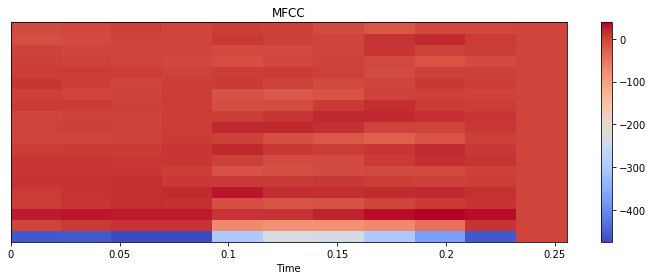

In [15]:
def print_sample(sample):
    import matplotlib.pyplot as plt
    import librosa.display
    plt.figure(figsize=(10, 4))
    print(sample.shape)  # 11帧，每帧20个特征
    librosa.display.specshow(sample, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    
print_sample(sample)

[ 0.00000000e+00 -1.00929366e-16 -8.07434927e-17 -9.58828976e-17
  4.03717464e-17 -2.82602224e-16 -1.21746048e-16  1.11022302e-16
  1.41301112e-16  5.55111512e-17  6.05576195e-17  8.07434927e-17
  0.00000000e+00 -3.02788098e-17  5.04646829e-17  6.05576195e-17
  1.00929366e-16 -2.52323415e-18  2.01858732e-17  1.00929366e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(20, 11)


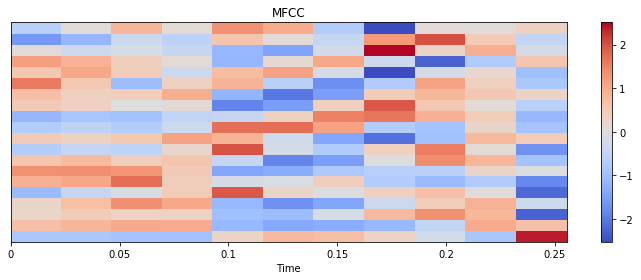

In [20]:
import sklearn
mfccs = sklearn.preprocessing.scale(sample, axis=1)  # normalization
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))
print_sample(mfccs)

(14861,) 16000
(20, 21)
(20, 21)


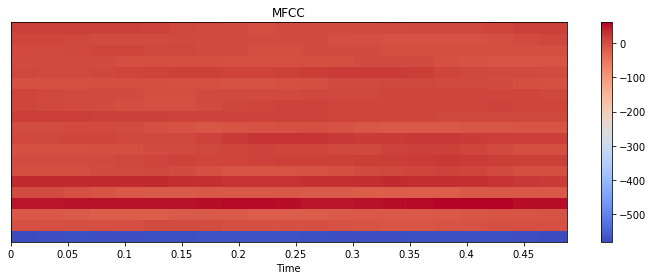

In [58]:
audio_fp = './data/bed/004ae714_nohash_1.wav'
wave, sr = librosa.load(audio_fp, mono=True, sr=None)
print(wave.shape, sr)
wave = wave[:1600]
# n_mfcc: mfcc的特征数量
# n_fft: 每帧的数量（1帧的数据，经过mfcc后会是一列）
# hop_length: 后一帧相对于前一帧后移的数量
# 具体可参考：https://github.com/librosa/librosa/issues/584， https://librosa.github.io/librosa/glossary.html
mfccs2 = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=20, n_fft=int(sr/20), hop_length=int(sr/200))
print(mfccs2.shape)
print_sample(mfccs2)